# Análise Exploratoria de Dados e Modelagem Preditiva de Churn

In [1]:
import pandas as pd

# Carregar os dados dos arquivos CSV
contracts_df = pd.read_csv('dados/churn_contracts.csv')
customers_df = pd.read_csv('dados/churn_customers.csv')
services_df = pd.read_csv('dados/churn_services.csv')

# Exibir as primeiras linhas de cada dataframe para inspeção inicial
contracts_df.head(), customers_df.head(), services_df.head()


(   customerID  tenure        Contract PaperlessBilling  \
 0  7590-VHVEG       1  Month-to-month              Yes   
 1  5575-GNVDE      34        One year               No   
 2  3668-QPYBK       2  Month-to-month              Yes   
 3  7795-CFOCW      45        One year               No   
 4  9237-HQITU       2  Month-to-month              Yes   
 
                PaymentMethod  MonthlyCharges TotalCharges Churn  
 0           Electronic check           29.85        29.85    No  
 1               Mailed check           56.95       1889.5    No  
 2               Mailed check           53.85       108.15   Yes  
 3  Bank transfer (automatic)           42.30      1840.75    No  
 4           Electronic check           70.70       151.65   Yes  ,
    customerID  gender  SeniorCitizen Partner Dependents
 0  7590-VHVEG  Female              0     Yes         No
 1  5575-GNVDE    Male              0      No         No
 2  3668-QPYBK    Male              0      No         No
 3  7795-CFOC

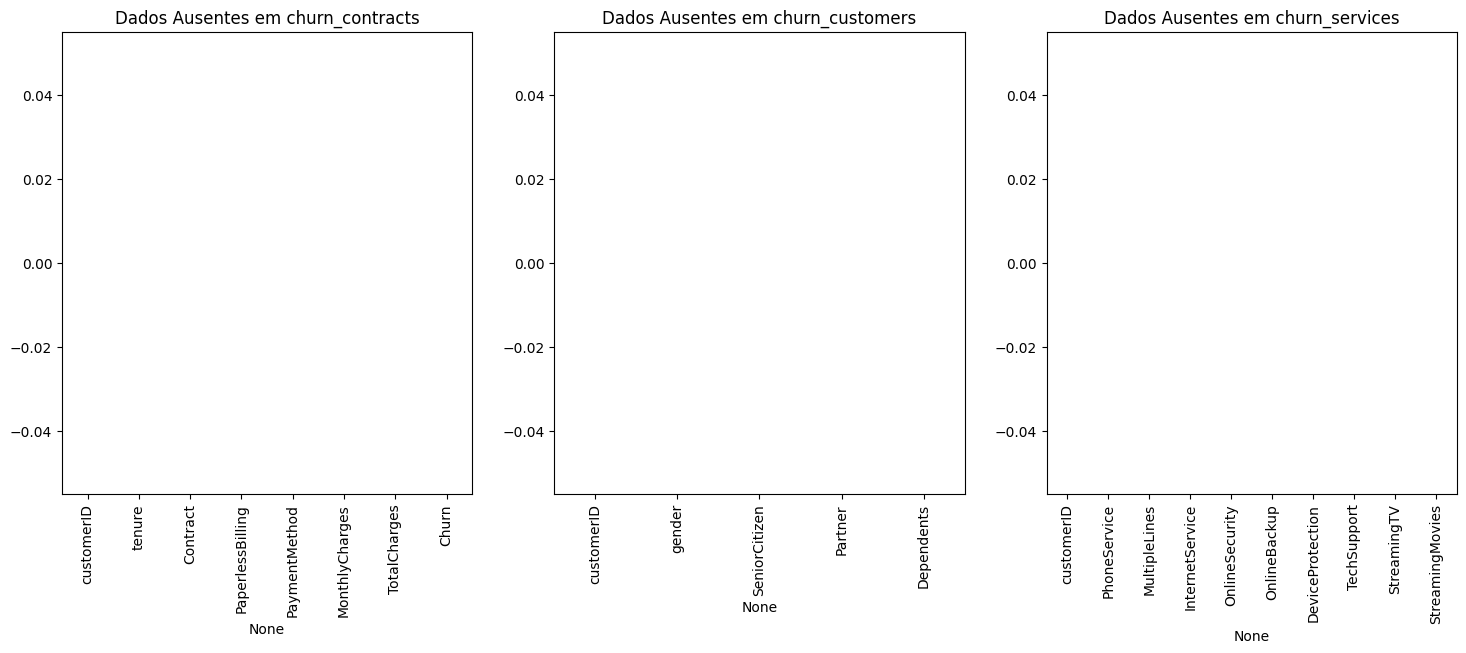

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar dados ausentes
missing_contracts = contracts_df.isnull().sum()
missing_customers = customers_df.isnull().sum()
missing_services = services_df.isnull().sum()

# Visualizar dados ausentes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=missing_contracts.index, y=missing_contracts.values, ax=axes[0])
axes[0].set_title('Dados Ausentes em churn_contracts')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(x=missing_customers.index, y=missing_customers.values, ax=axes[1])
axes[1].set_title('Dados Ausentes em churn_customers')
axes[1].tick_params(axis='x', rotation=90)

sns.barplot(x=missing_services.index, y=missing_services.values, ax=axes[2])
axes[2].set_title('Dados Ausentes em churn_services')
axes[2].tick_params(axis='x', rotation=90)

plt.show()

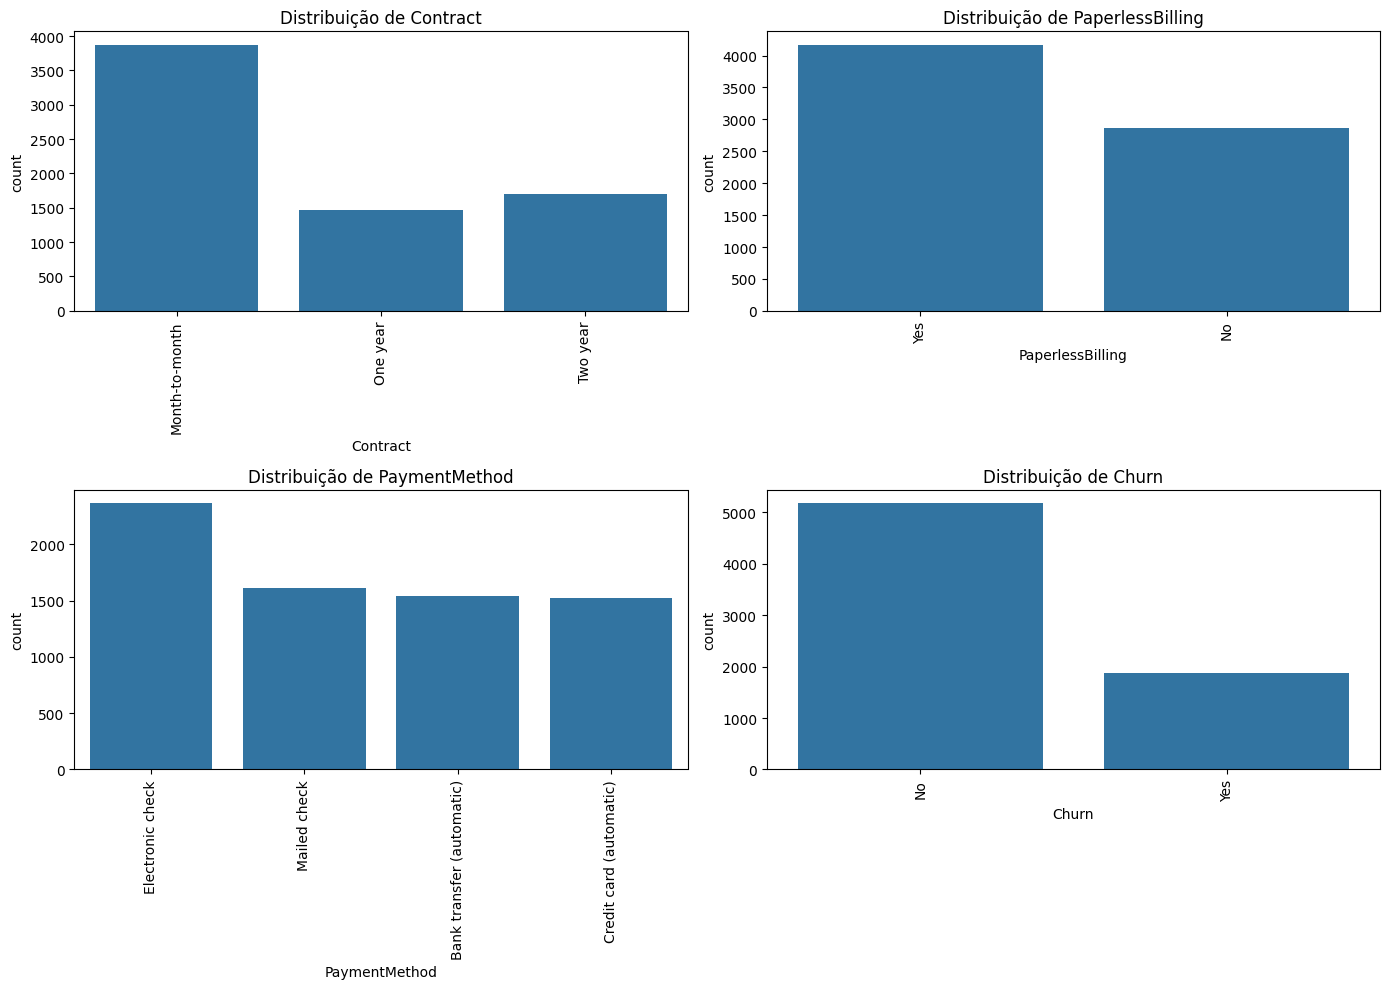

In [3]:
# Plotar a distribuição das variáveis categóricas em churn_contracts
cat_contracts = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(cat_contracts):
    sns.countplot(data=contracts_df, x=col, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribuição de {col}')
    axes[i//2, i%2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


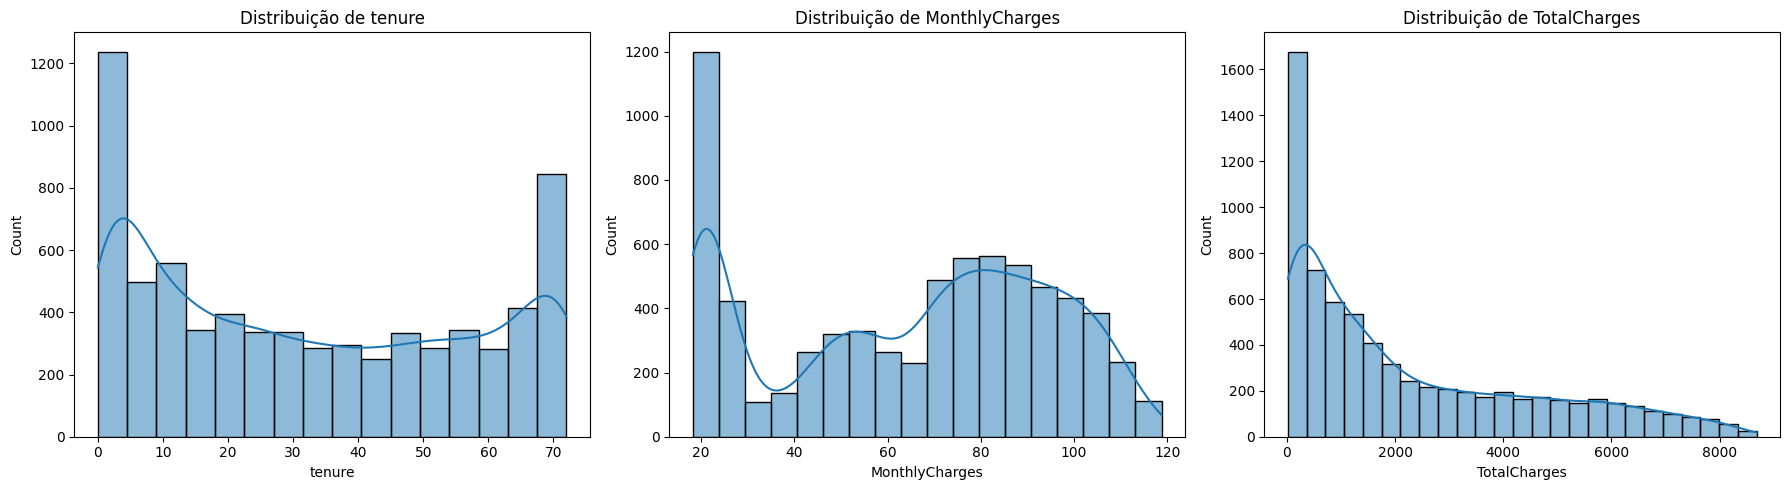

In [4]:
# Converter TotalCharges para numérico, substituindo espaços em branco por NaN
contracts_df['TotalCharges'] = pd.to_numeric(contracts_df['TotalCharges'], errors='coerce')

# Plotar a distribuição das variáveis numéricas em churn_contracts
num_contracts = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(num_contracts):
    sns.histplot(data=contracts_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()


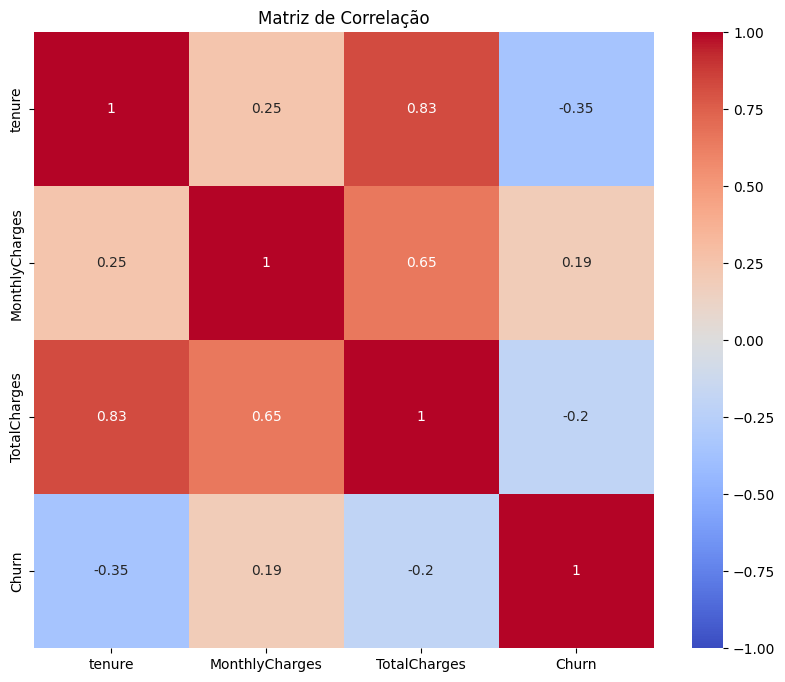

In [5]:
# Adicionar a coluna 'Churn' ao dataframe numérico para análise de correlação
contracts_df['Churn'] = contracts_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Calcular a matriz de correlação
corr_matrix = contracts_df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()

# Plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()


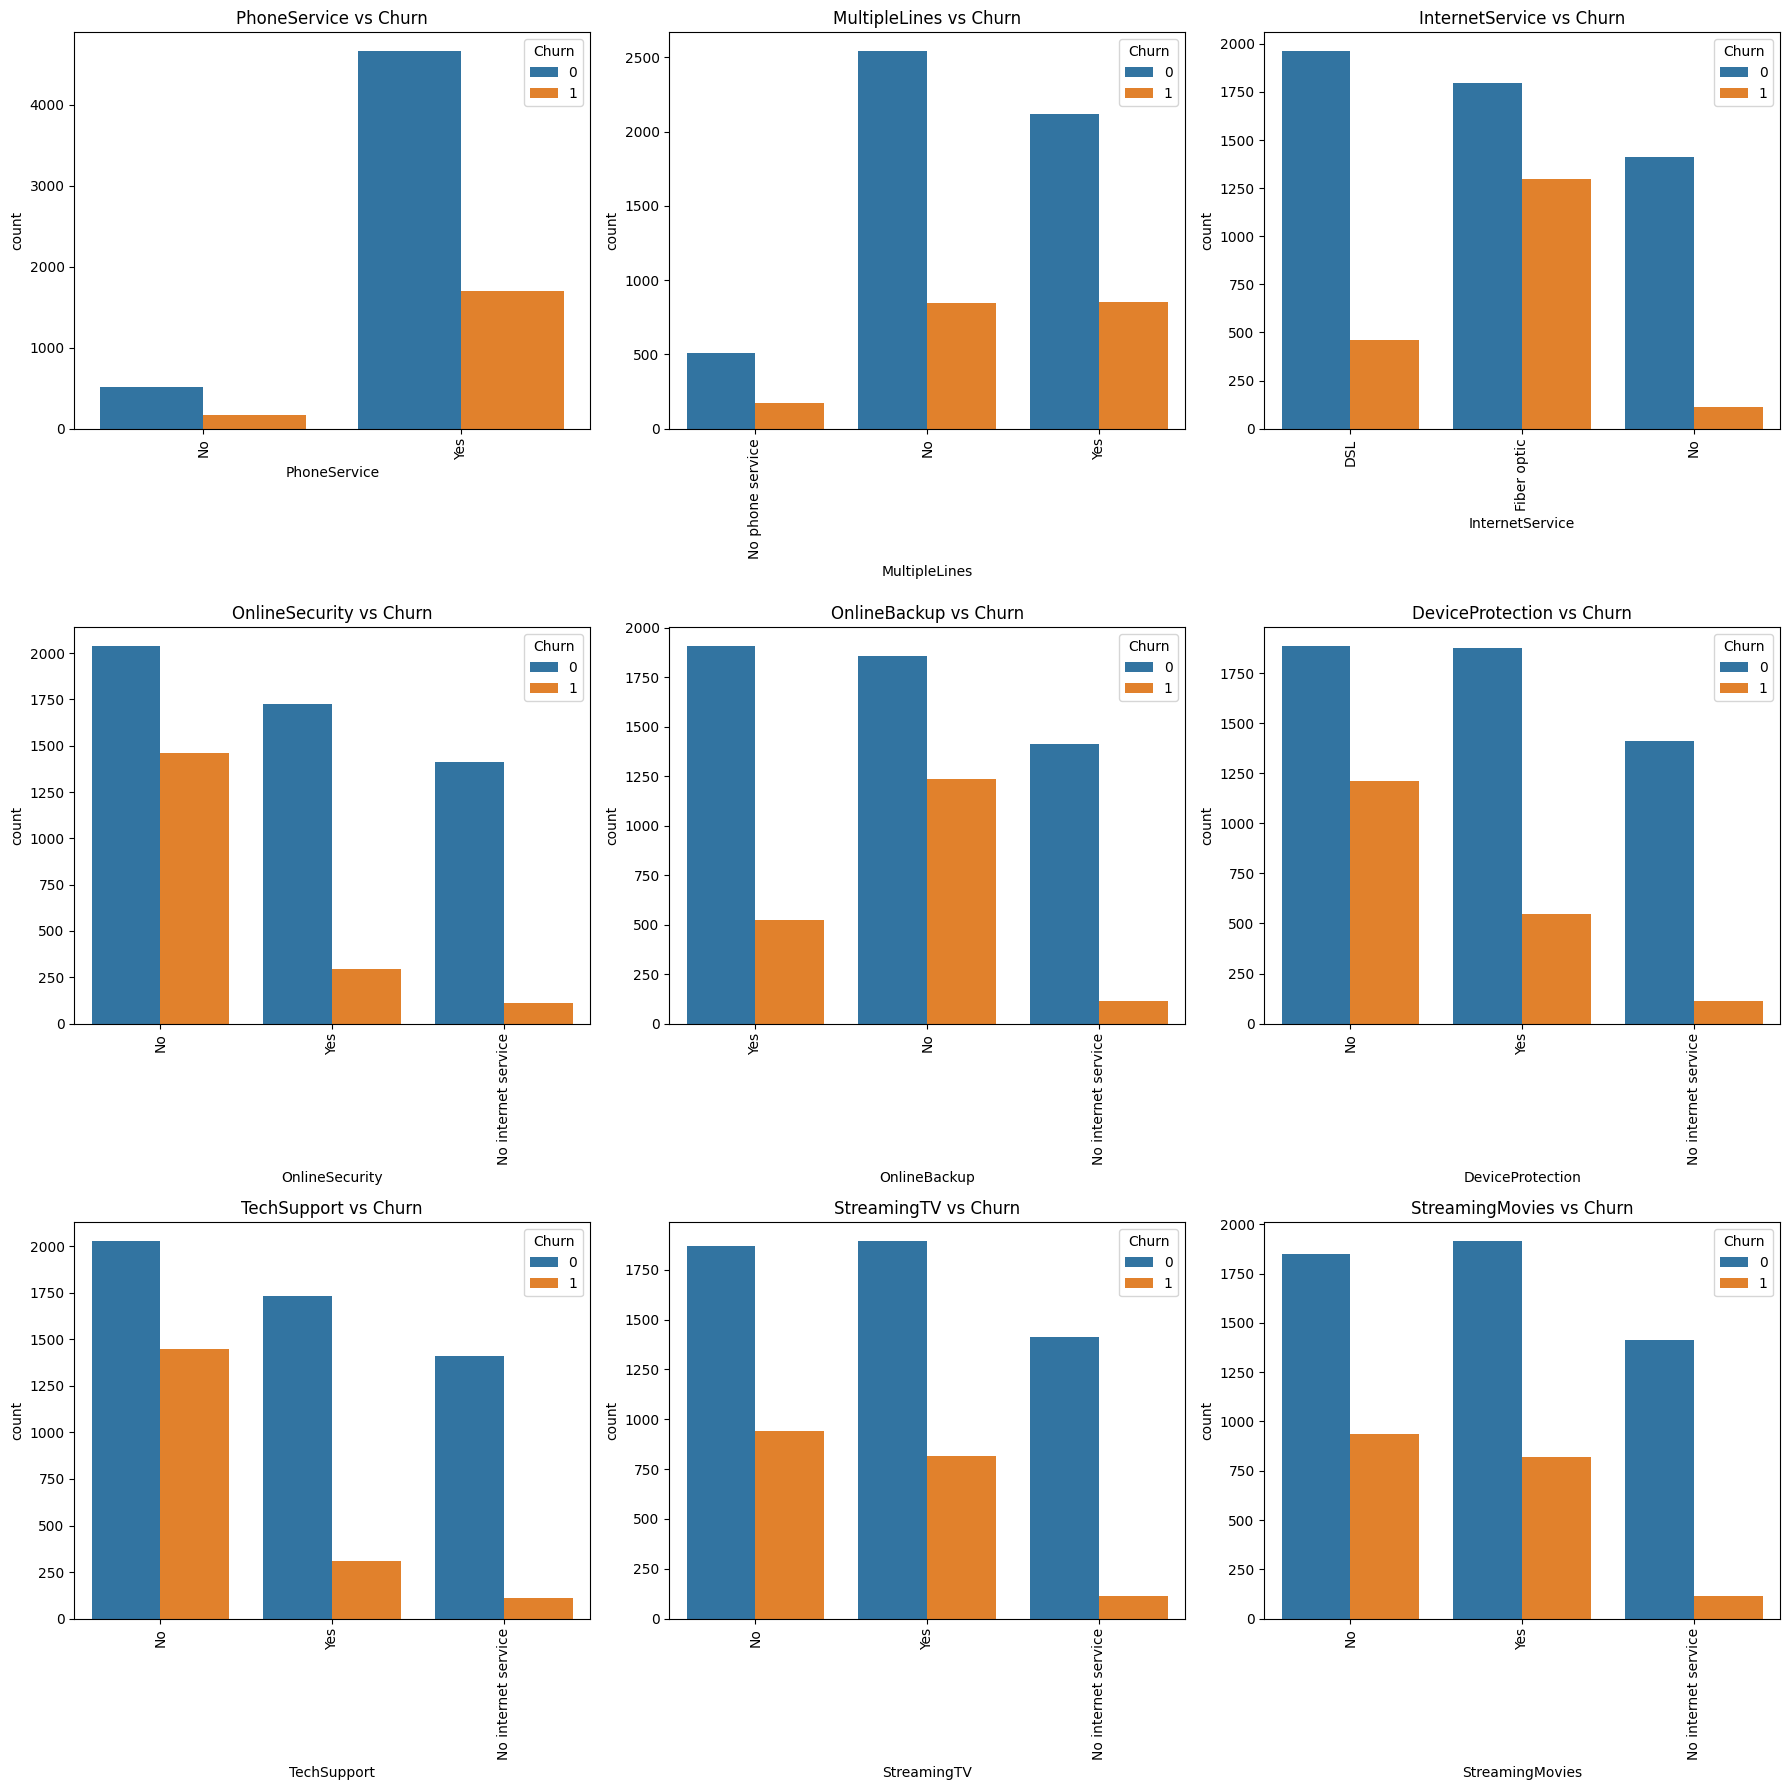

In [6]:
# Juntar os dados dos contratos e serviços com base no customerID
merged_df = pd.merge(contracts_df, services_df, on='customerID')

# Plotar a relação das variáveis de serviço com o churn
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, col in enumerate(service_cols):
    sns.countplot(data=merged_df, x=col, hue='Churn', ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} vs Churn')
    axes[i//3, i%3].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Selecionar features e target
features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 'PaperlessBilling',
            'PaymentMethod', 'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies']

X = merged_df[features]
y = merged_df['Churn']

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Definir o pré-processador
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [col for col in features if col not in numeric_features]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Definir o pipeline com RandomForestClassifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])

# Treinar o modelo
clf.fit(X_train, y_train)

# Fazer previsões
y_pred = clf.predict(X_test)

# Avaliar o modelo
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1552
           1       0.60      0.49      0.54       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.77      2113

Confusion Matrix:
[[1370  182]
 [ 284  277]]
Accuracy Score: 0.779460482725982


In [10]:
import streamlit as st
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# Função para carregar o modelo treinado
@st.cache(allow_output_mutation=True)
def load_model():
    return joblib.load('churn_model.pkl')

# Carregar o modelo
model = load_model()

# Definir a interface do usuário
st.title("Previsão de Churn de Clientes")
st.write("Insira as informações do cliente para prever se ele vai cancelar o serviço.")

# Inputs do usuário
tenure = st.number_input("Tenure (meses)", min_value=0, max_value=72, value=1)
monthly_charges = st.number_input("Monthly Charges", min_value=0.0, value=0.0)
total_charges = st.number_input("Total Charges", min_value=0.0, value=0.0)
contract = st.selectbox("Contract", ["Month-to-month", "One year", "Two year"])
paperless_billing = st.selectbox("Paperless Billing", ["Yes", "No"])
payment_method = st.selectbox("Payment Method", ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"])
phone_service = st.selectbox("Phone Service", ["Yes", "No"])
multiple_lines = st.selectbox("Multiple Lines", ["Yes", "No", "No phone service"])
internet_service = st.selectbox("Internet Service", ["DSL", "Fiber optic", "No"])
online_security = st.selectbox("Online Security", ["Yes", "No", "No internet service"])
online_backup = st.selectbox("Online Backup", ["Yes", "No", "No internet service"])
device_protection = st.selectbox("Device Protection", ["Yes", "No", "No internet service"])
tech_support = st.selectbox("Tech Support", ["Yes", "No", "No internet service"])
streaming_tv = st.selectbox("Streaming TV", ["Yes", "No", "No internet service"])
streaming_movies = st.selectbox("Streaming Movies", ["Yes", "No", "No internet service"])

# Botão para realizar a previsão
if st.button("Prever Churn"):
    # Organizar os dados de entrada em um dataframe
    input_data = pd.DataFrame({
        'tenure': [tenure],
        'MonthlyCharges': [monthly_charges],
        'TotalCharges': [total_charges],
        'Contract': [contract],
        'PaperlessBilling': [paperless_billing],
        'PaymentMethod': [payment_method],
        'PhoneService': [phone_service],
        'MultipleLines': [multiple_lines],
        'InternetService': [internet_service],
        'OnlineSecurity': [online_security],
        'OnlineBackup': [online_backup],
        'DeviceProtection': [device_protection],
        'TechSupport': [tech_support],
        'StreamingTV': [streaming_tv],
        'StreamingMovies': [streaming_movies]
    })

    # Fazer a previsão
    prediction = model.predict(input_data)
    prediction_proba = model.predict_proba(input_data)

    # Mostrar o resultado
    if prediction[0] == 1:
        st.error(f"Churn previsto com probabilidade de {prediction_proba[0][1]:.2f}")
    else:
        st.success(f"Não churn previsto com probabilidade de {prediction_proba[0][0]:.2f}")

InternalHashError: module '__main__' has no attribute '__file__'

While caching the body of `load_model()`, Streamlit encountered an
object of type `builtins.function`, which it does not know how to hash.

**In this specific case, it's very likely you found a Streamlit bug so please
[file a bug report here.]
(https://github.com/streamlit/streamlit/issues/new/choose)**

In the meantime, you can try bypassing this error by registering a custom
hash function via the `hash_funcs` keyword in @st.cache(). For example:

```
@st.cache(hash_funcs={builtins.function: my_hash_func})
def my_func(...):
    ...
```

If you don't know where the object of type `builtins.function` is coming
from, try looking at the hash chain below for an object that you do recognize,
then pass that to `hash_funcs` instead:

```
Object of type builtins.function: <function load_model at 0x000001B498EF00E0>
```

Please see the `hash_funcs` [documentation](https://docs.streamlit.io/library/advanced-features/caching#the-hash_funcs-parameter)
for more details.
            

In [ ]:
import joblib

# Salvar o modelo treinado
joblib.dump(clf, '/content/churn_model.pkl')
